In [1]:
import Pkg
Pkg.activate("..")

  Activating project at `~/research/xaqlab/ergm.jl`


In [2]:
using PyCall
py"""
import pickle
import networkx as nx
G = pickle.load(open("/home/will/research/xaqlab/ergm/G_proof_v6.p", "rb"))
"""

In [3]:
py"""
import numpy as np
import numpy.linalg as npl
import numpy.random as npr

layer_names = list(set([G.nodes[n]['layer'] for n in G.nodes]))
layers = {}

for layer in layer_names:
    layers[layer] = G.subgraph([n for n in G.nodes if G.nodes[n]['layer'] == layer])

def p(n):
    return np.array([G.nodes[n]['soma_' + i] for i in 'xyz'])

def subsample(layer, k, s):
    Hs = []
    layer_nodes = [n for n in G.nodes if G.nodes[n]['layer'] == layer]
    m = len(layer_nodes)
    ps = np.vstack([p(n) for n in layer_nodes])
    
    for _ in range(s):
        j0 = npr.randint(m)
        ds = npl.norm(ps - ps[j0, :], axis=1)
        js = np.argpartition(ds, k)[:k]
        ns = [layer_nodes[j] for j in js]
        Hs.append(G.subgraph(ns))
    
    return Hs
"""

In [4]:
using ergm.spaces

function nx_to_digraph(nx)
    A = py"nx.adjacency_matrix($nx).todense()"
    DiGraph(A .> 0)
end

function nx_to_ps(nx)
    py"np.vstack([p(n) for n in $nx.nodes])"
end

n = 30
layer = "L2/L3"
nxs = py"subsample($layer, $n, 10000)"
Gs = map(nx_to_digraph, nxs)
ps = map(nx_to_ps, nxs);

In [5]:
using ergm.stats
using LinearAlgebra
using Statistics
stats = SimpleStats(
    function(G)
        p = sum(G.adjacency) / (n * (n - 1))
        [
            p,
            tr(G.adjacency ^ 3) / (n * (n - 1) * (n - 2)) - p ^ 3
        ]
    end
)

SimpleStats(var"#1#2"(), UndefInitializer())

In [6]:
function resample(p)
    n = size(p, 1)
    d = [norm(p[i, :] - p[j, :]) for i ∈ 1:n, j ∈ 1:n]
    A = rand(Float64, (n, n)) .< 1.39e-2 * exp.(-d / 1.57e4)
    DiGraph(convert(Matrix{Bool}, A))
end

resample (generic function with 1 method)

In [7]:
Gs_d = [resample(p) for p ∈ ps];

In [8]:
ss = hcat([get_stats(stats, G) for G ∈ Gs]...)
ms = mean(ss, dims=2)

2×1 Matrix{Float64}:
 0.011164367816092216
 3.436399530450135e-6

In [9]:
ss_d = hcat([get_stats(stats, G) for G ∈ Gs_d]...)
ms_d = mean(ss_d, dims=2)

2×1 Matrix{Float64}:
  0.010772873563218533
 -4.233160885914272e-7

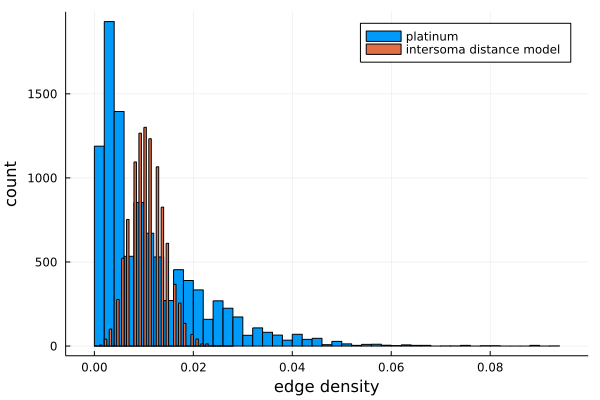

In [13]:
using Plots

histogram(ss[1, :], xlabel="edge density", ylabel="count", label="platinum")
histogram!(ss_d[1, :], label="intersoma distance model")

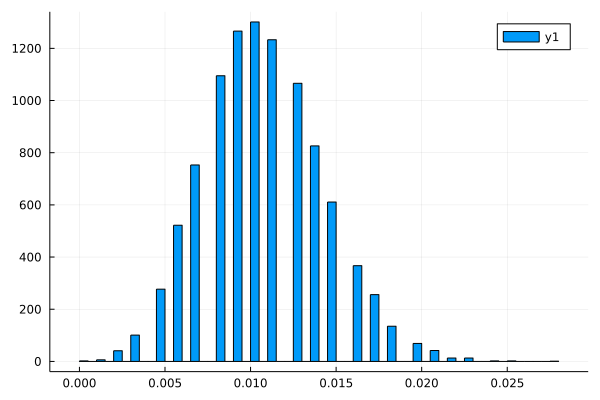

In [11]:
using Plots

histogram(ss_d[1, :])

# Connection Probability by Distance Bin

In [42]:
zip([1,2], [3, 4]) |> collect

2-element Vector{Tuple{Int64, Int64}}:
 (1, 3)
 (2, 4)

In [104]:
using Plots

ns = py"[n for n in G.nodes if G.nodes[n]['layer'] == $layer]"
ps = py"np.vstack([p(n) for n in $ns])"
n = size(ps, 1)
ds = [norm(ps[i, :] - ps[j, :]) for (i, j) ∈ zip(rand(1:n, 1000000), rand(1:n, 1000000))];

In [71]:
py"G.has_edge($ns[0], $ns[3])"

false

In [120]:
bin_width = 1e4
n_bins = 40
bins_n = zeros(n_bins)
bins_y = zeros(n_bins)
is = rand(1:n, 1000000)
js = rand(1:n, 1000000)
e = 0

for (i, j) ∈ zip(is, js)
    d = norm(ps[i, :] - ps[j, :])
    b = trunc(Int64, d ÷ bin_width) + 1
    
    if 1 ≤ b ≤ n_bins
        bins_n[b] += 1
        ni = ns[i]
        nj = ns[j]
        
        if py"G.has_edge($ni, $nj)"
            bins_y[b] += 1
        end
    else
        println(b)
        break
    end
end

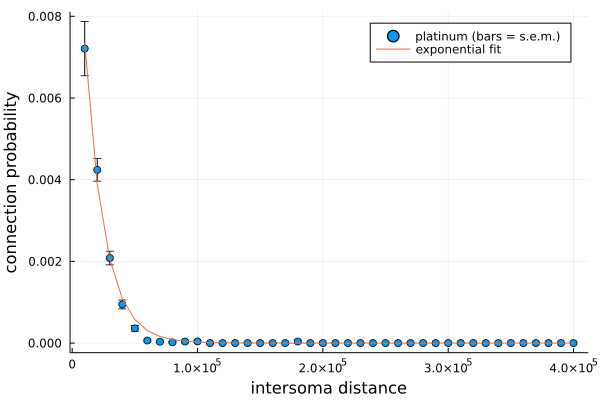

In [223]:
ps = replace(bins_y ./ bins_n, NaN => 0.0)
ds_p = bin_width * (1:n_bins)
sems = [sqrt(ps[i] * (1 - ps[i]) ^ 2) / sqrt(bins_n[i]) for i ∈ 1:n_bins]
scatter(ds_p, ps, label="platinum (bars = s.e.m.)", yerr=sems, xlabel="intersoma distance", ylabel="connection probability")
plot!(ds_p, 1.39e-2 * exp.(-ds_p / 1.57e4), label="exponential fit")

In [205]:
pyimport("sys")."stdout" = PyTextIO(stdout)
pyimport("sys")."stderr" = PyTextIO(stderr)

py"""
from scipy.optimize import curve_fit
import numpy as np

def model(x, a, b):
    return a * np.exp(-x / b)

xdata = $ds_p
ydata = $ps

popt, pcov = curve_fit(model, xdata, ydata, bounds=([0.0, 1e3], [10.0, 1e5]))
print(popt)
"""

[1.39060975e-02 1.56928463e+04]
